# Model 2 - MCMC with Turing.jl

![Model2](img/model2.png)
Taken from Figure 10 of Vincent (2015).

## Install Turing.jl (only need to do this once)
See the Turing instructions on their [wiki](https://github.com/yebai/Turing.jl/wiki/Get-started#install-turingjl) for more info.

In [1]:
#Pkg.add("Turing")
#Pkg.update()
#Pkg.checkout("Turing", "master") 
#Pkg.build("Turing")
#Pkg.test("Turing")

## Setup

In [2]:
using Turing

[Turing]: AD chunk size is set as 40


In [3]:
using Plots
using Distributions
using Mamba: describe, plot

## STEP 1: Define our data
This time we will generate our own data

In [19]:
data = Dict()
data["T"] = 100
data["Δμ"] = [0.0100, 0.0215, 0.0464, 0.1000, 0.2154, 0.4642, 1.0000, 2.1544, 4.6416, 10.0000];

In [20]:
function model2generate(Δμ, T; σ²=1, λ=0.01, b=0)
    x = zeros(length(Δμ), T, 2)
    L = zeros(length(Δμ), T)
    R = zeros(length(Δμ), T)
    for c ∈ 1:length(Δμ)
        for t ∈ 1:T
            # true location, L
            L[c,t] = rand(Categorical([0.5, 0.5]))
            
            # observer's observations, x
            for n ∈ 1:2
                if L[c,t] == n
                    x[c,t,n] = rand(Normal(Δμ[c], √σ²))
                else
                    x[c,t,n] = rand(Normal(0, √σ²))
                end
            end
            
            # observer response R given x, b, λ
            if x[c,t,1]-x[c,t,2] > b
                R[c,t] = rand(Categorical([1-(λ/2), λ/2]))
            else
                R[c,t] = rand(Categorical([λ/2, 1-(λ/2)]))
            end
            
        end
    end
    # calculate number correct responses (k) for each Δμ value
    k = sum(R .== L, 2)
    return L, R, k
end

# Generate true signal locations (L), and responses (R)
data["L"], data["R"], data["k"] = model2generate(data["Δμ"], data["T"])

([1.0 2.0 … 1.0 2.0; 1.0 1.0 … 1.0 2.0; … ; 2.0 2.0 … 2.0 2.0; 2.0 1.0 … 1.0 1.0], [1.0 2.0 … 1.0 1.0; 1.0 2.0 … 2.0 2.0; … ; 2.0 2.0 … 1.0 2.0; 2.0 1.0 … 1.0 1.0], [44; 42; … ; 99; 99])

In [25]:
plot_data_space = scatter(log.(data["Δμ"]), data["k"]./data["T"],
    xlabel = "log signal instensity, Δμ", #xscale = :log,
    ylabel = "proportion correct, k/T",
    legend = false)

# TODO: xaxis should be log scale
# TODO: get latex axis labels

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -4 
 
 
 -3 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
 
 2 
 
 
 0.5 
 
 
 0.6 
 
 
 0.7 
 
 
 0.8 
 
 
 0.9 
 
 
 1.0 
 
 
 log signal instensity, ?? 
 
 
 proportion correct, k/T

## STEP 2: conduct inference
First we are going to define a model. This is the way of doing it for the Turing package. I managed to convert this over from the JAGS specification (see the original Matlab repo) with not so much trouble. It's pretty nice in fact.

In [22]:
@model model2infer(Δμ,T,L,R) = begin
    σ² ~ Uniform(0,10)
    λ ~ Beta(1,1)
    b ~ Normal(0,10)
    x = zeros(length(Δμ), T, 2)
    for c ∈ 1:length(Δμ)
        for t ∈ 1:T
            # true location, L
            L[c,t] ~ Categorical([0.5, 0.5])
            
            # observer's observations, x
            for n ∈ 1:2
                if L[c,t] == n
                    x[c,t,n] = rand(Normal(Δμ[c], √σ²))
                else
                    x[c,t,n] = rand(Normal(0, √σ²))
                end
            end
            
            # observer response R given x, b, λ
            if x[c,t,1]-x[c,t,2] > b
                R[c,t] ~ Categorical([1-(λ/2), λ/2])
            else
                R[c,t] ~ Categorical([λ/2, 1-(λ/2)])
            end

        end
    end
    return σ², λ, b
end

model2infer (generic function with 5 methods)

## Invoke sampling
We will simultanously sample from the posterior distribution over $\sigma^2$ as well as the posterior predictive

# NOTE: RESULTS OF SAMPLING ARE CURRENTLY WRONG. THIS IS WORK IN PROGRESS

In [23]:
n_samples = 300
samples = sample( model2infer(data["Δμ"], data["T"], data["L"], data["R"]), PG(50,n_samples))
describe(samples)

[Turing]:  Assume - `σ²` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `λ` is a parameter
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Assume - `b` is a parameter (ignoring `b` found in global scope)
 @~(::ANY, ::ANY) at compiler.jl:76
[Turing]:  Observe - `L` is an observation
 @~(::ANY, ::ANY) at compiler.jl:57
[Turing]:  Observe - `R` is an observation
 @~(::ANY, ::ANY) at compiler.jl:57


[PG] Sampling... 99%  ETA: 0:00:01

[PG] Finished with
  Running time    = 195.12313237399994;


[PG] Sampling...100% Time: 0:03:15


Iterations = 1:300
Thinning interval = 1
Chains = 1
Samples per chain = 300

Empirical Posterior Estimates:
            Mean               SD                      Naive SE              MCSE       ESS   
      b -0.74156502 0.0000000000000001112078 0.0000000000000000064205855 0.000000000 300.00000
      λ  0.36849057 0.0000000000000005560390 0.0000000000000000321029276 0.000000000 300.00000
elapsed  0.65041044 0.0394547533751102436073 0.0022779212481930195474678 0.004403817  80.26757
     σ²  6.49561527 0.0000000000000026689873 0.0000000000000001540940527 0.000000000 300.00000
     lp  0.00000000 0.0000000000000000000000 0.0000000000000000000000000 0.000000000       NaN

Quantiles:
            2.5%       25.0%       50.0%       75.0%       97.5%   
      b -0.74156502 -0.74156502 -0.74156502 -0.74156502 -0.74156502
      λ  0.36849057  0.36849057  0.36849057  0.36849057  0.36849057
elapsed  0.60757366  0.62905517  0.64295182  0.65649837  0.77640911
     σ²  6.49561527  6.49561527  6.495

In [8]:
σ²posterior = samples[:σ²]
λposterior = samples[:λ]
b = samples[:b];

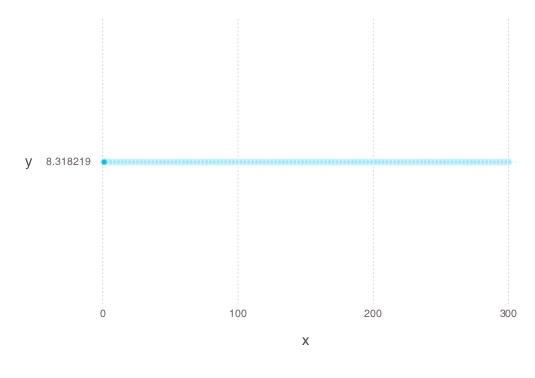

In [9]:
plot(x = 1:n_samples, y = σ²posterior)

# Visualisation
Plot data and posterior predictions in data space

Plot posterior in parameter space

In [ ]:
# TODO - plot histogram of samples

In [ ]:
# TODO - calculate summary stats of samples

Should end up with something like this, Figure 11 from Vincent (2015)
![Model2](img/model2results.png)

## References
Vincent, B. T. (2015). A tutorial on Bayesian models of perception. Journal of Mathematical Psychology, 66, 103–114. http://doi.org/10.1016/j.jmp.2015.02.001